In [ ]:
pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

spark=SparkSession.builder \
    .appName("ICICIStockAnalysis") \
    .getOrCreate()

In [ ]:
from pyspark.sql.types import StructType, StructField, DateType, DoubleType, IntegerType
schema = StructType([
    StructField("Date", DateType(), False),       # Date column as DateType, non-nullable
    StructField("Adj Close", DoubleType(), False), # 'Adj Close' as DoubleType, non-nullable
    StructField("Close", DoubleType(), False),    # 'Close' as DoubleType, non-nullable
    StructField("High", DoubleType(), False),     # 'High' as DoubleType, non-nullable
    StructField("Low", DoubleType(), False),      # 'Low' as DoubleType, non-nullable
    StructField("Open", DoubleType(), False),     # 'Open' as DoubleType, non-nullable
    StructField("Volume", IntegerType(), False)   # 'Volume' as IntegerType, non-nullable
])

In [ ]:
df=spark.read.csv('/content/ICICIBANK.csv',header=False,schema=schema)

In [ ]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: integer (nullable = true)



In [ ]:
df.show(8)

+----------+-----------+-----------+-----------+-----------+-----------+-------+
|      Date|  Adj Close|      Close|       High|        Low|       Open| Volume|
+----------+-----------+-----------+-----------+-----------+-----------+-------+
|      NULL|       NULL|       NULL|       NULL|       NULL|       NULL|   NULL|
|      NULL|       NULL|       NULL|       NULL|       NULL|       NULL|   NULL|
|      NULL|       NULL|       NULL|       NULL|       NULL|       NULL|   NULL|
|2002-07-01|17.83141708|25.12727165|25.81818008|24.81818008|25.41818047|2047540|
|2002-07-02|18.97974968|26.74545479|27.63636208|25.23636246|25.45454407|5546354|
|2002-07-03| 19.9345417|28.09090805|28.18181801|26.64545441|26.72727203|5745267|
|2002-07-04|19.43779373|27.39090919|28.79999924| 27.0363636|28.18181801|3896601|
|2002-07-05|19.63778496|27.67272758|27.86363602|26.94545364|27.09090805|3261038|
+----------+-----------+-----------+-----------+-----------+-----------+-------+
only showing top 8 rows



In [ ]:
# Counting NULL values in all columns
null_count = df.filter(df['Volume'].isNull()).count()
print(f"Number of NULL values in all columns: {null_count}")

Number of NULL values in all columns: 3


In [ ]:
# a) Calculate Daily Returns
# Daily returns are the percentage change in the closing price from one day to the next. This metric helps understand price fluctuations.

from pyspark.sql.functions import lag,col
from pyspark.sql.window import Window

# Create a window to calculate the previous day's Close price
window_spec=Window.orderBy("Date")
# Calculate daily returns as a percentage change from the previous day
df=df.withColumn("Prev Close",lag("Close").over(window_spec))
# lag("Close") is a PySpark function that returns the value of the Close column for the previous row (relative to the current row) based on the window specification (window_spec).

# over(window_spec) applies the window specification (in this case, ordering by Date).

# withColumn("Prev_Close", ...) creates a new column called Prev_Close where each row will contain the closing price of the previous day based on the sorted order of the dates.

df=df.withColumn("Daily Return",(col("Close")-col("Prev Close"))/col("Prev Close")*100)

In [ ]:
# b) Calculate Moving Averages
# Moving averages smooth out price data, making trends more visible. You can calculate a 50-day and 200-day moving average.
from pyspark.sql.functions import avg
from pyspark.sql.window import Window

# .rowsBetween(-49, 0): This means that for each row, we will look at the previous 49 rows (up to 49 days) and the current row to compute the average. This is how the 50-day moving average is calculated. The number 49 represents the previous 49 days, and the 0 represents the current day.
# Similarly, .rowsBetween(-199, 0) looks at the previous 199 rows (up to 199 days) and the current row to compute the 200-day moving average.

window_50=Window.orderBy("Date").rowsBetween(-49,0)
window_200=Window.orderBy("Date").rowsBetween(-199,0)

df=df.withColumn("SMA_50",avg("Close").over(window_50))
df=df.withColumn("SMA_200",avg("Close").over(window_200))

In [ ]:
# Drop rows where essential columns have null values
df=df.dropna(subset=["Date","Adj Close","Close","High","Low","Open","Volume","Prev Close","Daily Return"])

In [ ]:
df.show()

+----------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+------------------+------------------+
|      Date|  Adj Close|      Close|       High|        Low|       Open| Volume| Prev Close|        Daily Return|            SMA_50|           SMA_200|
+----------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+------------------+------------------+
|2002-07-02|18.97974968|26.74545479|27.63636208|25.23636246|25.45454407|5546354|25.12727165|  6.4399476494695325|       25.93636322|       25.93636322|
|2002-07-03| 19.9345417|28.09090805|28.18181801|26.64545441|26.72727203|5745267|26.74545479|   5.030586582147252|26.654544830000003|26.654544830000003|
|2002-07-04|19.43779373|27.39090919|28.79999924| 27.0363636|28.18181801|3896601|28.09090805| -2.4919054191984404|       26.83863592|       26.83863592|
|2002-07-05|19.63778496|27.67272758|27.86363602|26.94545364|27.09090805|3261038|27.39090

In [ ]:
from pyspark.sql.functions import round
df = df.select(
    "Date",
    round("Adj Close", 2).alias("Adj_Close"),
    round("Close", 2).alias("Close"),
    round("High", 2).alias("High"),
    round("Low", 2).alias("Low"),
    round("Open", 2).alias("Open"),
    "Volume",
    round("Prev Close",2).alias("Prev_Close"),
    round("Daily return",2).alias("Daily_return"),
    round("SMA_50",2).alias("SMA_50"),
    round("SMA_200",2).alias("SMA_200")
)


In [ ]:
df.show(5)

+----------+---------+-----+-----+-----+-----+-------+----------+------------+------+-------+
|      Date|Adj_Close|Close| High|  Low| Open| Volume|Prev_Close|Daily_return|SMA_50|SMA_200|
+----------+---------+-----+-----+-----+-----+-------+----------+------------+------+-------+
|2002-07-02|    18.98|26.75|27.64|25.24|25.45|5546354|     25.13|        6.44| 25.94|  25.94|
|2002-07-03|    19.93|28.09|28.18|26.65|26.73|5745267|     26.75|        5.03| 26.65|  26.65|
|2002-07-04|    19.44|27.39| 28.8|27.04|28.18|3896601|     28.09|       -2.49| 26.84|  26.84|
|2002-07-05|    19.64|27.67|27.86|26.95|27.09|3261038|     27.39|        1.03| 27.01|  27.01|
|2002-07-08|    19.33|27.25|27.89|27.17|27.88|2092667|     27.67|       -1.54| 27.05|  27.05|
+----------+---------+-----+-----+-----+-----+-------+----------+------------+------+-------+
only showing top 5 rows



In [ ]:
# Count duplicate rows
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 0


In [ ]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Adj_Close: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Prev_Close: double (nullable = true)
 |-- Daily_return: double (nullable = true)
 |-- SMA_50: double (nullable = true)
 |-- SMA_200: double (nullable = true)



In [ ]:
df.describe(["Adj_Close","Close","High","Low","Open","Volume","Prev_Close","Daily_return","SMA_50","SMA_200"]).show()
# Interpretation:
# ● High standard deviation in daily returns indicates high volatility.
# ● The average daily return gives an idea of the typical daily price change.

+-------+------------------+------------------+-----------------+-----------------+------------------+--------------------+------------------+-------------------+------------------+-----------------+
|summary|         Adj_Close|             Close|             High|              Low|              Open|              Volume|        Prev_Close|       Daily_return|            SMA_50|          SMA_200|
+-------+------------------+------------------+-----------------+-----------------+------------------+--------------------+------------------+-------------------+------------------+-----------------+
|  count|              5554|              5554|             5554|             5554|              5554|                5554|              5554|               5554|              5554|             5554|
|   mean| 292.4489232985242|312.15711199135706|316.0974522866393|308.1571498019455| 312.2551692473894| 1.899857925333093E7|311.93590745408665|0.09953006841915746|  306.664159164566|290.9495696795104|


In [ ]:
df.tail(5)

[Row(Date=datetime.date(2024, 11, 7), Adj_Close=1278.7, Close=1278.7, High=1302.8, Low=1275.25, Open=1297.15, Volume=9909035, Prev_Close=1302.35, Daily_return=-1.82, SMA_50=1265.66, SMA_200=1156.8),
 Row(Date=datetime.date(2024, 11, 8), Adj_Close=1258.85, Close=1258.85, High=1275.0, Low=1252.7, Open=1270.0, Volume=11195808, Prev_Close=1278.7, Daily_return=-1.55, SMA_50=1266.4, SMA_200=1158.05),
 Row(Date=datetime.date(2024, 11, 11), Adj_Close=1269.3, Close=1269.3, High=1275.9, Low=1246.65, Open=1262.0, Volume=8387780, Prev_Close=1258.85, Daily_return=0.83, SMA_50=1267.2, SMA_200=1159.49),
 Row(Date=datetime.date(2024, 11, 12), Adj_Close=1270.6, Close=1270.6, High=1295.0, Low=1264.5, Open=1276.15, Volume=13486168, Prev_Close=1269.3, Daily_return=0.1, SMA_50=1268.02, SMA_200=1160.91),
 Row(Date=datetime.date(2024, 11, 13), Adj_Close=1253.7, Close=1253.7, High=1276.25, Low=1250.0, Open=1270.6, Volume=12259953, Prev_Close=1270.6, Daily_return=-1.33, SMA_50=1268.14, SMA_200=1162.18)]

In [ ]:
df.show(5)

+----------+---------+-----+-----+-----+-----+-------+----------+------------+------+-------+
|      Date|Adj_Close|Close| High|  Low| Open| Volume|Prev_Close|Daily_return|SMA_50|SMA_200|
+----------+---------+-----+-----+-----+-----+-------+----------+------------+------+-------+
|2002-07-02|    18.98|26.75|27.64|25.24|25.45|5546354|     25.13|        6.44| 25.94|  25.94|
|2002-07-03|    19.93|28.09|28.18|26.65|26.73|5745267|     26.75|        5.03| 26.65|  26.65|
|2002-07-04|    19.44|27.39| 28.8|27.04|28.18|3896601|     28.09|       -2.49| 26.84|  26.84|
|2002-07-05|    19.64|27.67|27.86|26.95|27.09|3261038|     27.39|        1.03| 27.01|  27.01|
|2002-07-08|    19.33|27.25|27.89|27.17|27.88|2092667|     27.67|       -1.54| 27.05|  27.05|
+----------+---------+-----+-----+-----+-----+-------+----------+------------+------+-------+
only showing top 5 rows



In [ ]:
# Creating Temporary Table
df.registerTempTable("icici")

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [ ]:
spark.sql("""
SELECT
Date,
Close,
SMA_50,
SMA_200,
CASE WHEN SMA_50 > SMA_200 THEN 'Uptrend' ELSE 'Downtrend' END
AS Trend
FROM icici
ORDER BY Date
""").tail(5)

[Row(Date=datetime.date(2024, 11, 7), Close=1278.7, SMA_50=1265.66, SMA_200=1156.8, Trend='Uptrend'),
 Row(Date=datetime.date(2024, 11, 8), Close=1258.85, SMA_50=1266.4, SMA_200=1158.05, Trend='Uptrend'),
 Row(Date=datetime.date(2024, 11, 11), Close=1269.3, SMA_50=1267.2, SMA_200=1159.49, Trend='Uptrend'),
 Row(Date=datetime.date(2024, 11, 12), Close=1270.6, SMA_50=1268.02, SMA_200=1160.91, Trend='Uptrend'),
 Row(Date=datetime.date(2024, 11, 13), Close=1253.7, SMA_50=1268.14, SMA_200=1162.18, Trend='Uptrend')]

In [ ]:
df.tail(5)

[Row(Date=datetime.date(2024, 11, 7), Adj_Close=1278.7, Close=1278.7, High=1302.8, Low=1275.25, Open=1297.15, Volume=9909035, Prev_Close=1302.35, Daily_return=-1.82, SMA_50=1265.66, SMA_200=1156.8),
 Row(Date=datetime.date(2024, 11, 8), Adj_Close=1258.85, Close=1258.85, High=1275.0, Low=1252.7, Open=1270.0, Volume=11195808, Prev_Close=1278.7, Daily_return=-1.55, SMA_50=1266.4, SMA_200=1158.05),
 Row(Date=datetime.date(2024, 11, 11), Adj_Close=1269.3, Close=1269.3, High=1275.9, Low=1246.65, Open=1262.0, Volume=8387780, Prev_Close=1258.85, Daily_return=0.83, SMA_50=1267.2, SMA_200=1159.49),
 Row(Date=datetime.date(2024, 11, 12), Adj_Close=1270.6, Close=1270.6, High=1295.0, Low=1264.5, Open=1276.15, Volume=13486168, Prev_Close=1269.3, Daily_return=0.1, SMA_50=1268.02, SMA_200=1160.91),
 Row(Date=datetime.date(2024, 11, 13), Adj_Close=1253.7, Close=1253.7, High=1276.25, Low=1250.0, Open=1270.6, Volume=12259953, Prev_Close=1270.6, Daily_return=-1.33, SMA_50=1268.14, SMA_200=1162.18)]

In [ ]:
df.write.csv('/content/sample_data/cleaned_icici.csv',header=True)

In [ ]:
#3.4 volume analysis

spark.sql("""
 SELECT
Date,
Volume,
Close,
Daily_return
FROM icici
ORDER BY Volume DESC
""").show()

+----------+---------+------+------------+
|      Date|   Volume| Close|Daily_return|
+----------+---------+------+------------+
|2019-11-26|286857658| 510.7|        2.59|
|2009-03-06|277252228| 48.94|       -0.33|
|2008-10-10|196556492| 66.12|      -19.86|
|2009-03-31|188785256| 60.51|       -1.57|
|2011-11-30|175381222|129.54|       -2.93|
|2009-03-17|175129680|  58.8|        0.19|
|2008-10-13|167420044|  77.3|       16.91|
|2009-05-19|164921339|137.48|        6.94|
|2009-03-12|150544240| 51.66|        8.06|
|2009-04-27|147298052| 85.01|        7.71|
|2009-03-05|143672595|  49.1|       -5.21|
|2009-03-13|143489280| 56.12|        8.62|
|2009-04-09|139573351| 72.33|        5.69|
|2008-09-17|139525716|101.83|       -6.03|
|2009-03-04|139103426|  51.8|       -3.62|
|2009-05-06|136625368| 98.11|       -5.18|
|2009-03-03|134327787| 53.75|       -2.89|
|2009-04-02|129391559| 65.58|        3.25|
|2017-05-31|128437479|296.77|        1.57|
|2009-05-05|127386138|103.47|         7.4|
+----------

In [ ]:
#3.5 Seasonal Patterns Analysis
from pyspark.sql.functions import month

df_monthly=df.withColumn("Month",month("Date"))
df_monthly.groupby("Month").avg("Close","Volume").orderBy("Month").show()

+-----+------------------+--------------------+
|Month|        avg(Close)|         avg(Volume)|
+-----+------------------+--------------------+
|    1|311.88756465517247| 1.824935280387931E7|
|    2|313.46138568129345| 1.805872689838337E7|
|    3|295.28484513274344| 2.353100746017699E7|
|    4|  301.102185273159| 2.237189463182898E7|
|    5| 310.4539186295505|2.0704726453961454E7|
|    6|309.11963675213684|1.7384882888888888E7|
|    7| 308.5412103174603| 1.769223497420635E7|
|    8|314.32929896907217| 1.794891115257732E7|
|    9|  324.965894736842| 1.787948482736842E7|
|   10| 329.1294623655915|1.9384070176344085E7|
|   11|320.62512195121974|1.9299934838137474E7|
|   12| 305.8269509594882| 1.607342941151386E7|
+-----+------------------+--------------------+



In [ ]:
#3.6  Identify High and Low Volatility Periods

spark.sql("""
 SELECT
 Date,
 Close,
 Daily_Return
 FROM icici
ORDER BY ABS(Daily_Return) DESC
 LIMIT 10
 """).show()

+----------+------+------------+
|      Date| Close|Daily_Return|
+----------+------+------------+
|2009-05-18|128.56|       23.04|
|2008-10-10| 66.12|      -19.86|
|2020-03-23| 284.0|      -17.85|
|2008-10-13|  77.3|       16.91|
|2008-10-31|  72.5|       15.46|
|2017-10-25| 305.7|       14.69|
|2008-10-24| 56.95|      -14.38|
|2003-08-21| 32.43|       13.85|
|2020-04-07| 326.1|       13.76|
|2008-03-17|138.17|      -13.34|
+----------+------+------------+



In [ ]:
# 4.1 Correlation Analysis
# a) Correlation between Close Price and Volume

spark.sql("""
 SELECT corr(Close, Volume) AS Close_Volume_Correlation
 FROM icici
 """).show()


+------------------------+
|Close_Volume_Correlation|
+------------------------+
|    -0.04235595358939078|
+------------------------+



In [ ]:
# b) Correlation Among Other Variables

spark.sql("""
 SELECT
 corr(Open, Close) AS Open_Close_Correlation,
 corr(High, Close) AS High_Close_Correlation,
 corr(Low, Close) AS Low_Close_Correlation,
 corr(Volume, Close) AS Volume_Close_Correlation
 FROM icici
 """).show()

+----------------------+----------------------+---------------------+------------------------+
|Open_Close_Correlation|High_Close_Correlation|Low_Close_Correlation|Volume_Close_Correlation|
+----------------------+----------------------+---------------------+------------------------+
|    0.9997858961994837|    0.9999106231140906|   0.9999017945425975|    -0.04235595358939...|
+----------------------+----------------------+---------------------+------------------------+



In [ ]:
# 4.2 Trend Analysis with Moving Averages
# a) Crossovers in Moving Averages

spark.sql("""
 SELECT
 Date,
 Close,
 SMA_50,
 SMA_200,
 CASE
 WHEN SMA_50 > SMA_200 THEN 'Uptrend'
 ELSE 'Downtrend'
 END AS Trend
 FROM icici
 ORDER BY Date
 """).show(10)

+----------+-----+------+-------+---------+
|      Date|Close|SMA_50|SMA_200|    Trend|
+----------+-----+------+-------+---------+
|2002-07-02|26.75| 25.94|  25.94|Downtrend|
|2002-07-03|28.09| 26.65|  26.65|Downtrend|
|2002-07-04|27.39| 26.84|  26.84|Downtrend|
|2002-07-05|27.67| 27.01|  27.01|Downtrend|
|2002-07-08|27.25| 27.05|  27.05|Downtrend|
|2002-07-09|27.09| 27.05|  27.05|Downtrend|
|2002-07-10|26.99| 27.04|  27.04|Downtrend|
|2002-07-11|26.79| 27.02|  27.02|Downtrend|
|2002-07-12|26.79| 26.99|  26.99|Downtrend|
|2002-07-15|26.37| 26.94|  26.94|Downtrend|
+----------+-----+------+-------+---------+
only showing top 10 rows



In [ ]:
# 4.3 Price Volatility Analysis

#a) Calculate Rolling Standard Deviation (Volatility)

spark.sql("""
 SELECT
 Date,
 Close,
 Daily_Return,
 stddev(Daily_Return) OVER (ORDER BY Date ROWS BETWEEN 29
 PRECEDING AND CURRENT ROW) AS Volatility_30
 FROM icici
 ORDER BY Date
 """).show(10)

+----------+-----+------------+------------------+
|      Date|Close|Daily_Return|     Volatility_30|
+----------+-----+------------+------------------+
|2002-07-02|26.75|        6.44|              NULL|
|2002-07-03|28.09|        5.03|0.9970205614730321|
|2002-07-04|27.39|       -2.49| 4.800753413093964|
|2002-07-05|27.67|        1.03| 4.040852839026271|
|2002-07-08|27.25|       -1.54|3.9388742046427434|
|2002-07-09|27.09|       -0.57| 3.642261202421741|
|2002-07-10|26.99|       -0.37| 3.385478091017856|
|2002-07-11|26.79|       -0.74|3.1994081483924495|
|2002-07-12|26.79|         0.0| 3.006115063961754|
|2002-07-15|26.37|       -1.56|2.9271679525135252|
+----------+-----+------------+------------------+
only showing top 10 rows



In [ ]:
# 4.4 Detecting Seasonal Patterns

# a) Monthly Trends in Closing Prices

spark.sql("""
 SELECT
 MONTH(Date) AS Month,
 AVG(Close) AS Avg_Close
 FROM icici
 GROUP BY MONTH(Date)
 ORDER BY Month
 """).show()

+-----+------------------+
|Month|         Avg_Close|
+-----+------------------+
|    1|311.88756465517247|
|    2|313.46138568129345|
|    3|295.28484513274344|
|    4|  301.102185273159|
|    5| 310.4539186295505|
|    6|309.11963675213684|
|    7| 308.5412103174603|
|    8|314.32929896907217|
|    9|  324.965894736842|
|   10| 329.1294623655915|
|   11|320.62512195121974|
|   12| 305.8269509594882|
+-----+------------------+



In [ ]:
#  4.5 Detect Anomalous Trends

spark.sql("""
 SELECT
 Date,
 Close,
 Daily_Return
 FROM icici
 WHERE ABS(Daily_Return) > (SELECT AVG(Daily_Return) + 3 *
 STDDEV(Daily_Return) FROM icici)
 ORDER BY ABS(Daily_Return) DESC
 """).show(10)

+----------+------+------------+
|      Date| Close|Daily_Return|
+----------+------+------------+
|2009-05-18|128.56|       23.04|
|2008-10-10| 66.12|      -19.86|
|2020-03-23| 284.0|      -17.85|
|2008-10-13|  77.3|       16.91|
|2008-10-31|  72.5|       15.46|
|2017-10-25| 305.7|       14.69|
|2008-10-24| 56.95|      -14.38|
|2003-08-21| 32.43|       13.85|
|2020-04-07| 326.1|       13.76|
|2008-03-17|138.17|      -13.34|
+----------+------+------------+
only showing top 10 rows



In [ ]:
# 5.1 Moving Average Crossover Strategy (50-day & 200-day)

from pyspark.sql.window import Window
from pyspark.sql.functions import avg, when, col

# Define Window for Moving Averages
window_50 = Window.orderBy("Date").rowsBetween(-49, 0)  # 50-day window
window_200 = Window.orderBy("Date").rowsBetween(-199, 0)  # 200-day window

# Compute Moving Averages
df = df.withColumn("MA_50", avg("Close").over(window_50))
df = df.withColumn("MA_200", avg("Close").over(window_200))

# Identify crossover points
df = df.withColumn("Signal",
                   when(col("MA_50") > col("MA_200"), "Bullish")  # Buy Signal
                   .when(col("MA_50") < col("MA_200"), "Bearish")  # Sell Signal
                   .otherwise("Neutral"))

df.select("Date", "Close", "MA_50", "MA_200", "Signal").show(10)

+----------+-----+------------------+------------------+-------+
|      Date|Close|             MA_50|            MA_200| Signal|
+----------+-----+------------------+------------------+-------+
|2002-07-02|26.75|             26.75|             26.75|Neutral|
|2002-07-03|28.09|             27.42|             27.42|Neutral|
|2002-07-04|27.39|             27.41|             27.41|Neutral|
|2002-07-05|27.67|            27.475|            27.475|Neutral|
|2002-07-08|27.25|             27.43|             27.43|Neutral|
|2002-07-09|27.09|27.373333333333335|27.373333333333335|Neutral|
|2002-07-10|26.99| 27.31857142857143| 27.31857142857143|Neutral|
|2002-07-11|26.79|           27.2525|           27.2525|Neutral|
|2002-07-12|26.79| 27.20111111111111| 27.20111111111111|Neutral|
|2002-07-15|26.37|27.118000000000002|27.118000000000002|Neutral|
+----------+-----+------------------+------------------+-------+
only showing top 10 rows



In [ ]:
# 5.2 Volatility Analysis (Rolling Standard Deviation)

from pyspark.sql.functions import stddev

# Compute 30-day Rolling Standard Deviation
window_volatility = Window.orderBy("Date").rowsBetween(-29, 0)  # 30-day window
df = df.withColumn("Rolling_Volatility", stddev("Close").over(window_volatility))

df.select("Date", "Close", "Rolling_Volatility").show(10)


+----------+-----+-------------------+
|      Date|Close| Rolling_Volatility|
+----------+-----+-------------------+
|2002-07-02|26.75|               NULL|
|2002-07-03|28.09| 0.9475230867899735|
|2002-07-04|27.39| 0.6702238432046416|
|2002-07-05|27.67| 0.5624648137143041|
|2002-07-08|27.25|0.49739320461783576|
|2002-07-09|27.09|0.46603290298718913|
|2002-07-10|26.99| 0.4494229103872575|
|2002-07-11|26.79| 0.4561249828720204|
|2002-07-12|26.79| 0.4536640950208779|
|2002-07-15|26.37| 0.5020137226986713|
+----------+-----+-------------------+
only showing top 10 rows



In [ ]:
# 5.3  Outlier Detection (Anomalous Returns)

from pyspark.sql.functions import abs, mean

# Compute mean & std dev of daily returns
daily_return_mean = df.agg(mean("Daily_Return")).collect()[0][0]
daily_return_std = df.agg(stddev("Daily_Return")).collect()[0][0]

# Identify outliers (returns greater than 2 standard deviations from mean)
df = df.withColumn("Outlier", when(abs(col("Daily_Return") - daily_return_mean) > 2 * daily_return_std, "Yes").otherwise("No"))

df.select("Date", "Close", "Daily_Return", "Outlier").filter(col("Outlier") == "Yes").show(10)


+----------+-----+------------+-------+
|      Date|Close|Daily_Return|Outlier|
+----------+-----+------------+-------+
|2002-07-02|26.75|        6.44|    Yes|
|2002-07-03|28.09|        5.03|    Yes|
|2002-10-18|23.55|       -5.23|    Yes|
|2002-10-24|22.46|       -4.96|    Yes|
|2002-11-13| 20.1|       -5.59|    Yes|
|2002-11-14|21.54|        7.15|    Yes|
|2002-11-22|23.52|        7.17|    Yes|
|2002-11-25|25.04|        6.46|    Yes|
|2002-12-13|27.18|        5.47|    Yes|
|2003-04-30|22.03|       -6.81|    Yes|
+----------+-----+------------+-------+
only showing top 10 rows



In [ ]:
# 5.4 Trend Identification (Long-Term vs. Short-Term)

from pyspark.sql.functions import when

# Define trend conditions
df = df.withColumn("Trend",
                   when(col("Close") > col("MA_200"), "Uptrend")  # Above 200-day MA
                   .when(col("Close") < col("MA_200"), "Downtrend")  # Below 200-day MA
                   .otherwise("Sideways"))

df.select("Date", "Close", "Trend").show(10)


+----------+-----+---------+
|      Date|Close|    Trend|
+----------+-----+---------+
|2002-07-02|26.75| Sideways|
|2002-07-03|28.09|  Uptrend|
|2002-07-04|27.39|Downtrend|
|2002-07-05|27.67|  Uptrend|
|2002-07-08|27.25|Downtrend|
|2002-07-09|27.09|Downtrend|
|2002-07-10|26.99|Downtrend|
|2002-07-11|26.79|Downtrend|
|2002-07-12|26.79|Downtrend|
|2002-07-15|26.37|Downtrend|
+----------+-----+---------+
only showing top 10 rows



In [ ]:
import pandas as pd

# Convert PySpark DataFrame to Pandas
df_pandas = df.select("Date", "Close", "MA_50", "MA_200", "Rolling_Volatility", "Daily_Return", "Outlier").toPandas()

# Convert Date column to datetime format
df_pandas["Date"] = pd.to_datetime(df_pandas["Date"])

# Sort by Date
df_pandas = df_pandas.sort_values("Date")


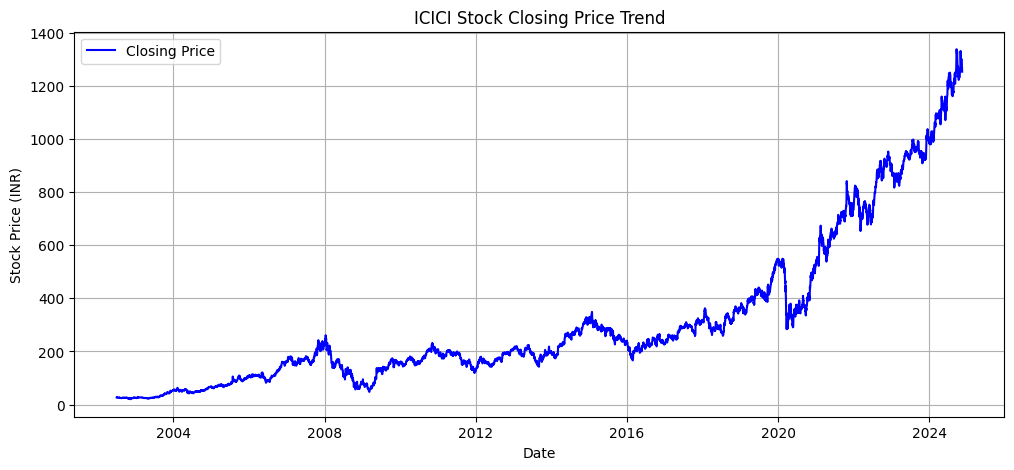

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_pandas["Date"], df_pandas["Close"], label="Closing Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price (INR)")
plt.title("ICICI Stock Closing Price Trend")
plt.legend()
plt.grid()
plt.show()


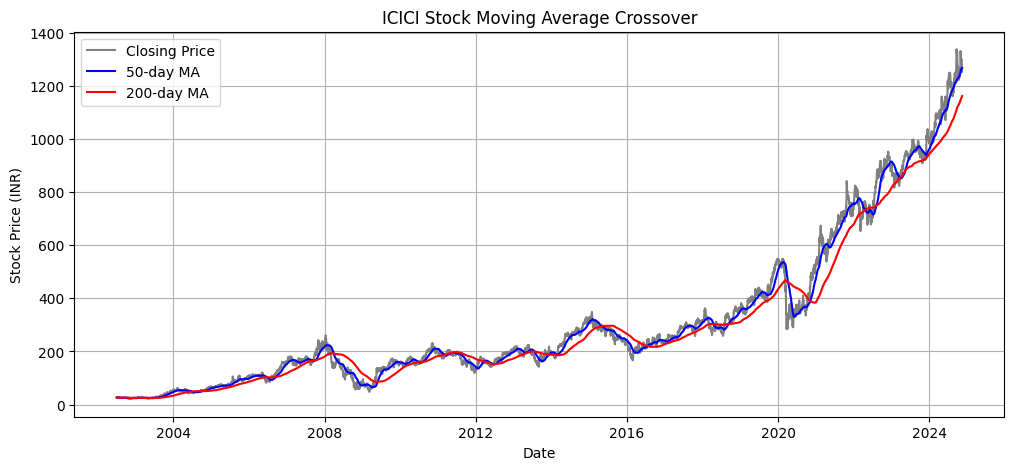

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_pandas["Date"], df_pandas["Close"], label="Closing Price", color="gray")
plt.plot(df_pandas["Date"], df_pandas["MA_50"], label="50-day MA", color="blue")
plt.plot(df_pandas["Date"], df_pandas["MA_200"], label="200-day MA", color="red")

plt.xlabel("Date")
plt.ylabel("Stock Price (INR)")
plt.title("ICICI Stock Moving Average Crossover")
plt.legend()
plt.grid()
plt.show()


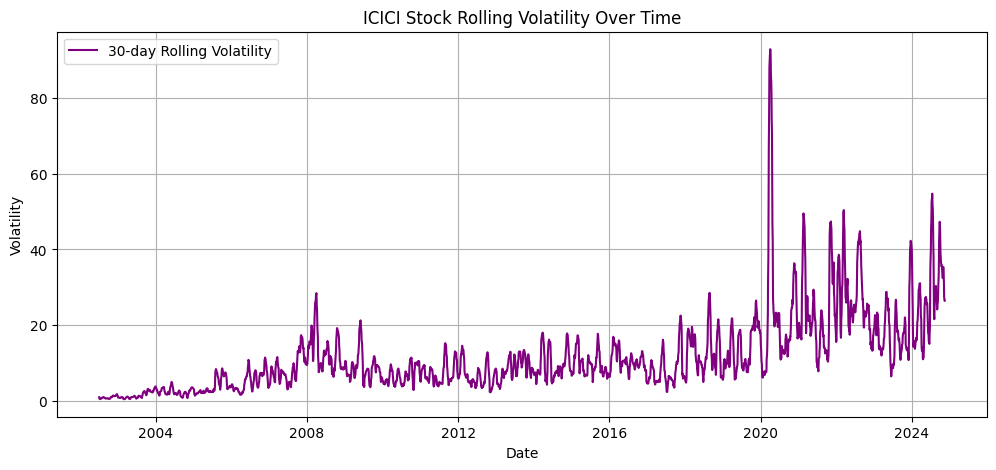

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_pandas["Date"], df_pandas["Rolling_Volatility"], label="30-day Rolling Volatility", color="purple")

plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("ICICI Stock Rolling Volatility Over Time")
plt.legend()
plt.grid()
plt.show()


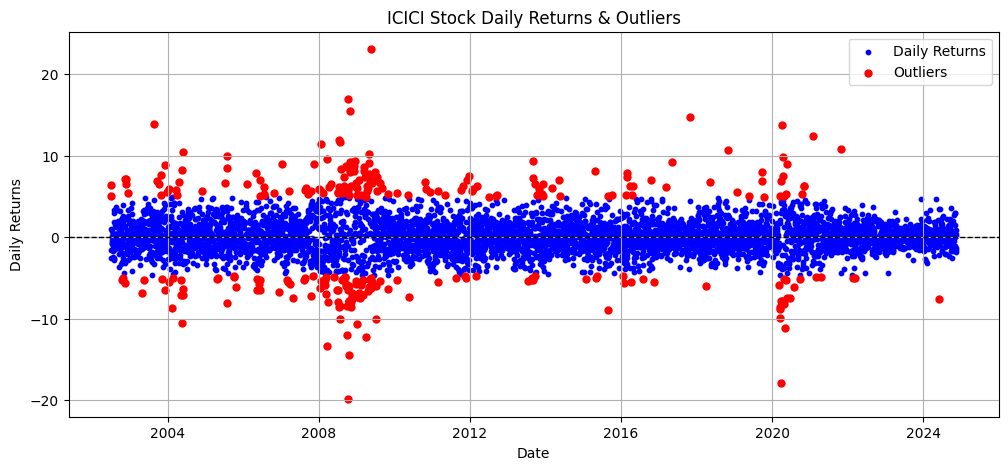

In [ ]:
plt.figure(figsize=(12, 5))
plt.scatter(df_pandas["Date"], df_pandas["Daily_Return"], label="Daily Returns", color="blue", s=10)

# Highlight Outliers
outlier_dates = df_pandas[df_pandas["Outlier"] == "Yes"]
plt.scatter(outlier_dates["Date"], outlier_dates["Daily_Return"], label="Outliers", color="red", s=25)

plt.axhline(y=0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.title("ICICI Stock Daily Returns & Outliers")
plt.legend()
plt.grid()
plt.show()
